<span style="color:red">
Note: This should not be merged into python-neo, but helps me figure out how to write axonarawio.py. I will add it to the axonarawio branch for now, but should delete it before a PR!
</span>.


# Read axona .bin file

We will go through the steps for reading in Axona dacqUSB system .bin data in continuous format.
The goal is to later implement this in axonarawio.py.

Here is the relevant information from the dacqUSB manual (found here: http://space-memory-navigation.org/DacqUSBFileFormats.pdf):


### Header
The header consists of:
* 4 bytes ID (will be "ADU1", unless the tracker position record is populated with valid data,
in which case it will be "ADU2")
* 4 bytes packet number
* 2 bytes digital inputs
* 2 bytes sync inputs
* 20 bytes tracker position record (only valid data if packet ID is "ADU2") -- same format as
standard .pos file position records.

### Data
Then there are three samples x 64 channels x 16-bits (= 384 bytes), followed by 16
dummy bytes at the end to make up the total packet length of 432. The samples order is
given below. Each sample is two bytes long, in 2's complement.
The data are stored at 48 kHz, so you should have 16000 packets of 432 bytes per second
of recording. Yes, this is very inefficient because you don't have anywhere near 64
channels so it is mostly wasted space; this will be improved in a future version update.
The main complication is that the order of the channels in the data file is not something
nice like 1,2,3, ... Instead, there is a remapping function:
<p>
remap_channels : array [1..64] of word = (
 32, 33, 34, 35, 36, 37, 38, 39,
 0, 1, 2, 3, 4, 5, 6, 7,
 40, 41, 42, 43, 44, 45, 46, 47,
 8, 9, 10, 11, 12, 13, 14, 15,
 48, 49, 50, 51, 52, 53, 54, 55,
 16, 17, 18, 19, 20, 21, 22, 23,
 56, 57, 58, 59, 60, 61, 62, 63,
 24, 25, 26, 27, 28, 29, 30, 31 ); 
</p>

For instance, if you want to find the data for channel 7, you look at remap_channels[7],
which is 38. So, in the 432-byte packet, you ignore the 32 byte header, and the data for
channel 7 will be at:
* bytes 32(header)+(38*2), and 32+(38*2+1) (first sample low and high bytes)
* bytes 32(header)+128(first samples, 64 ch x 2 bytes)+(38*2), and 32+128+(38*2+1) (2nd sample) 
* bytes 32+128+128+(38*2), and 32+128+128+(38*2+1) (third sample) and so on.

### Trailer
Finally, the trailer consists of 16 bytes:
2 bytes contain a record of digital output values
2 bytes contain stimulator status
10 bytes of zeroes (reserved for future use)
2 bytes contain the ASCII keycode if a key was pressed during the time the packet was
active. 

In [1]:
# Imports

import os
import sys
import mmap  # python library for memory mapping
import numpy as np  # contains np.memmap for memory mapping (used in python-neo)
import contextlib  # useful for managing contexts
import datetime
import re
#from urllib.request import urlopen  # maybe I can use the data from the gin repo (not supported atm)

In [2]:
# Set directory and filename

dir_name = r'../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw'
base_filename = '20201004_Raw'

bin_file = os.path.join(dir_name, base_filename + '.bin')
set_file = os.path.join(dir_name, base_filename + '.set') 

print(bin_file)
print(set_file)

../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/20201004_Raw.bin
../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/20201004_Raw.set


Create a small example file (400 ms) to upload on https://gin.g-node.org/NeuralEnsemble/ephy_testing_data

In [3]:
with open(bin_file, 'rb') as f:
    content = f.read(int(48000*432*0.4))
    
print(sys.getsizeof(content))

8294433


In [4]:
example_filename = 'axona_raw'
example_bin_file = os.path.join(dir_name, example_filename + '.bin')
f = open(example_bin_file, 'w+b')
f.write(content)

8294400

In [5]:
# Read the first 432 bytes and look at them

with open(bin_file, 'rb') as f:
    content = f.read(432)

print(content)

b'ADU1\x8d\x04\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xeex\xe88\xeex\xccl\xe2\x84\xea\x1e\x03J\t^\x07l\xe2<\xffb\xfdl\xef\xd6\xee8\xf1\\\xea\x8czJ\xf8\x9a\xfa8\xf1\xc2\x1a\x80\r\xc4\xf0\xd8\x06\x1e\x15\xc0\xf6\xbc\x06\xb0\x03\xce\xfb\x1e\x15\xfa\xef\xf6\rb\x0e\xb2\x06\xf0(|%\n\xed,1\xbcJ\xf0(\xe6\xfe"\x03f\xf9\xd8\x03\x10\x140\x1d\x02\x1a\xb2\x15\xa8A\x10\x14\x86\t\xe0\xf7\x1e\x07\xde\x06x\xf3\x0e\xf4\xa2\xa8\xfc\xca\xce\xedx\xf3j\x11\xa2\x16\x16\x04\x94\xe82\xff\xfc\xe8:\xb1>\x03v\xf82\xff\xea\xdb\xc8\xe7Z\xf0\x9c\xf0\xd8\xfc\x1a\xd7\x0c\xe6\x10\xe9\x1e\xd1\xd8\xfc\xba\xd5\xb6\xe3\x90\xe7P\xe0\x90\xe7j\xe9v\xff\xae\xe9p\xde\x90\xe7l\x12F\x02\x84\x0f\xe4\x11\xce\x06\x1a\xff\xe2\xf0D\xff\xbc\x14\xce\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

Note the substantial amount of wasted space (always assuming 64 channels)

In [6]:
# Read the first 432 * 2 bytes and look at them

with open(bin_file, 'rb') as f:
    content = f.read(432 * 2)

print(content)

b'ADU1\x8d\x04\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xeex\xe88\xeex\xccl\xe2\x84\xea\x1e\x03J\t^\x07l\xe2<\xffb\xfdl\xef\xd6\xee8\xf1\\\xea\x8czJ\xf8\x9a\xfa8\xf1\xc2\x1a\x80\r\xc4\xf0\xd8\x06\x1e\x15\xc0\xf6\xbc\x06\xb0\x03\xce\xfb\x1e\x15\xfa\xef\xf6\rb\x0e\xb2\x06\xf0(|%\n\xed,1\xbcJ\xf0(\xe6\xfe"\x03f\xf9\xd8\x03\x10\x140\x1d\x02\x1a\xb2\x15\xa8A\x10\x14\x86\t\xe0\xf7\x1e\x07\xde\x06x\xf3\x0e\xf4\xa2\xa8\xfc\xca\xce\xedx\xf3j\x11\xa2\x16\x16\x04\x94\xe82\xff\xfc\xe8:\xb1>\x03v\xf82\xff\xea\xdb\xc8\xe7Z\xf0\x9c\xf0\xd8\xfc\x1a\xd7\x0c\xe6\x10\xe9\x1e\xd1\xd8\xfc\xba\xd5\xb6\xe3\x90\xe7P\xe0\x90\xe7j\xe9v\xff\xae\xe9p\xde\x90\xe7l\x12F\x02\x84\x0f\xe4\x11\xce\x06\x1a\xff\xe2\xf0D\xff\xbc\x14\xce\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

At a glance it seems sensible to use f.read() 432 byte snippet by 432 byte snippet since there is no global header or footer. 
Note that the pointer moves with every call to f.read(), if I want to reset it to the beginning I could use f.seek(0)

In [7]:
# How many 432 byte packets does this data contain (<=> num. samples / 3)?

bytes_packet = 432

num_packets = int(os.path.getsize(bin_file)/bytes_packet)
print(num_packets)

9600100


In [8]:
# Windows tells me the .bin file is 4147243200  bytes

print('Bytes according to mmap_obj:', num_packets * bytes_packet)
print('Bytes according to Windows OS:', 4147243200)

assert(num_packets * bytes_packet == 4147243200)

Bytes according to mmap_obj: 4147243200
Bytes according to Windows OS: 4147243200


In [9]:
# Try with np.memmap instead (used a lot in python-neo)

global_header_size = 0
raw_data = np.memmap(bin_file, dtype='int16', mode='r', offset=global_header_size)

print('Size of raw_data:', len(raw_data))
print('Peak at raw_data:', raw_data[16:26])
print('Type of raw_data:', type(raw_data))

Size of raw_data: 2073621600
Peak at raw_data: [ -4384  -6024  -4552 -13192  -7572  -5500    798   2378   1886  -7572]
Type of raw_data: <class 'numpy.memmap'>


In [10]:
# Get data with code snippet from BinConverter, using mmap library:
# https://github.com/HussainiLab/BinConverter/blob/master/BinConverter/core/readBin.py

# 1second = 48000 samples
# 1packet = 3 samples
num_test_samples = 48000 // 3 #num_packets  # read only 1s for testing purposes

bytes_packet = 432
bytes_data = 384
bytes_head = 32
bytes_tail = 16

with open(bin_file, 'rb') as f:

    with contextlib.closing(mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)) as mmap_obj:
        num_packets = int(len(mmap_obj)/bytes_packet)

        data = np.ndarray(shape=(num_test_samples,), 
                          dtype=(np.int16, (bytes_data//2)),  # replace num_test_samples with num_packets
                          buffer=mmap_obj[0:bytes_packet*num_test_samples],  # ultimately read all
                          offset=bytes_head, 
                          strides=(bytes_packet,)).reshape((-1, 1)).flatten()

In [11]:
def get_active_tetrode(set_filename):
    """in the .set files it will say collectMask_X Y for each tetrode number to tell you if
    it is active or not. T1 = ch1-ch4, T2 = ch5-ch8, etc."""
    active_tetrode = []
    active_tetrode_str = 'collectMask_'

    with open(set_filename, encoding='cp1252') as f:
        for line in f:

            # collectMask_X Y, where x is the tetrode number, and Y is eitehr on or off (1 or 0)
            if active_tetrode_str in line:
                tetrode_str, tetrode_status = line.split(' ')
                if int(tetrode_status) == 1:
                    # then the tetrode is saved
                    tetrode_str.find('_')
                    tet_number = int(tetrode_str[tetrode_str.find('_') + 1:])
                    active_tetrode.append(tet_number)

    return active_tetrode

In [12]:
def get_channel_from_tetrode(tetrode):
    """This function will take the tetrode number and return the Axona channel numbers
    i.e. Tetrode 1 = Ch1 -Ch4, Tetrode 2 = Ch5-Ch8, etc"""
    tetrode = int(tetrode)  # just in case the user gave a string as the tetrode

    return np.arange(1, 5) + 4 * (tetrode - 1)

In [13]:
active_tetrode_set = get_active_tetrode(set_file)
get_channel_from_tetrode(2)

array([5, 6, 7, 8])

In [14]:
active_tetrode_set

[1, 2, 3, 4]

In [15]:
def get_sample_indices(channel_number, samples):
    remap_channel = get_remap_chan(channel_number)

    indices_scalar = np.multiply(np.arange(samples), 64)
    sample_indices = indices_scalar + np.multiply(np.ones(samples), remap_channel)

    # return np.array([remap_channel, 64 + remap_channel, 64*2 + remap_channel])
    return (indices_scalar + np.multiply(np.ones(samples), remap_channel)).astype(int)

In [16]:
def get_remap_chan(chan_num):
    """There is re-mapping, thus to get the correct channel data, you need to incorporate re-mapping
    input will be a channel from 1 to 64, and will return the remapped channel"""

    remap_channels = np.array([32, 33, 34, 35, 36, 37, 38, 39, 0, 1, 2, 3, 4, 5,
                               6, 7, 40, 41, 42, 43, 44, 45, 46, 47, 8, 9, 10, 11,
                               12, 13, 14, 15, 48, 49, 50, 51, 52, 53, 54, 55, 16, 17,
                               18, 19, 20, 21, 22, 23, 56, 57, 58, 59, 60, 61, 62, 63,
                               24, 25, 26, 27, 28, 29, 30, 31])

    return remap_channels[chan_num - 1]

In [17]:
def samples_to_array(A, channels=[]):
    """This will take data matrix A, and convert it into a numpy array, there are three samples of
    64 channels in this matrix, however their channels do need to be re-mapped"""

    if channels == []:
        channels = np.arange(64) + 1
    else:
        channels = np.asarray(channels)

    A = np.asarray(A)

    sample_num = int(len(A) / 64)  # get the sample numbers

    sample_array = np.zeros((len(channels), sample_num))  # creating a 64x3 array of zeros (64 channels, 3 samples)

    for i, channel in enumerate(channels):
        sample_array[i, :] = A[get_sample_indices(channel, sample_num)]

    return sample_array

In [18]:
data_huss = samples_to_array(data, channels = [])

In [19]:
data_huss.shape

(64, 48000)

In [20]:
import matplotlib.pyplot as plt

def plot_data_snippet(data, start_idx=0, end_idx=None, Fs=48000, Nch=16):
    """Plot a data snippet from a Ch x samples array given a start index and
    end index. If Fs is supplied the x-axis is in seconds."""
    
    if end_idx is None:
        end_idx = len(data)
    
    plt.figure(figsize=(16,8))

    x = np.linspace(0, (end_idx-start_idx)/Fs, end_idx-start_idx)

    for irow in range(0, Nch):
        plt.plot(x.T, 80000*irow+data[irow,start_idx:end_idx], label='Ch'+str(irow))

    plt.xlabel("seconds", fontsize=20)
    plt.ylabel("channels", fontsize=20)
    plt.title("Example snippet of LFP data", fontsize=20)
    plt.show()

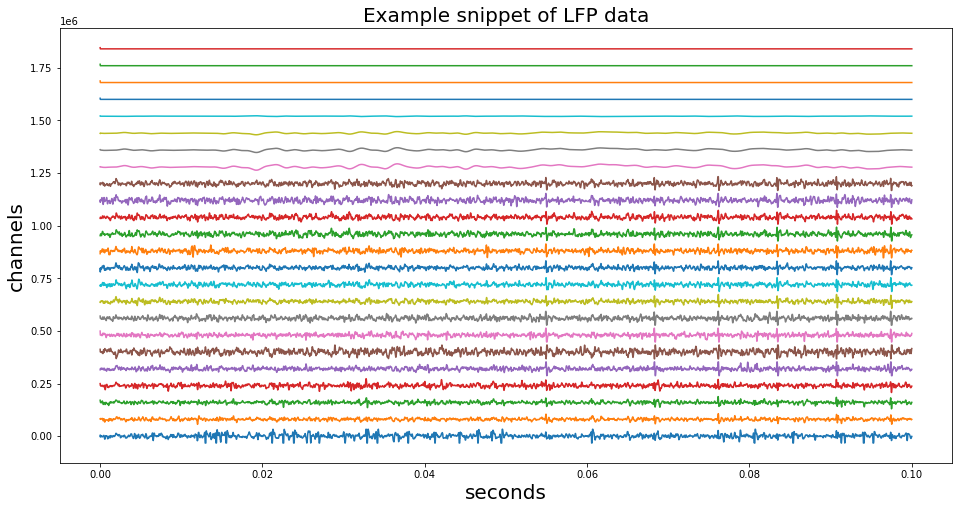

In [21]:
plot_data_snippet(data_huss, start_idx=0, end_idx=4800, Fs=48000, Nch = 24)

Why is there activity in channels 17-19 (just above the "normal" looking signals)?!

Should we use np.memmap and extract the data of interest in other functions of python-neo (e.g. in `_get_analogsignal_chunk`), or do we extract the array of data right away in `_parse_header`?

# Implement AxonaRawIO (step by step)

In [22]:
# Have a look at the .set file 
# Encoding is cp1252, even though it's supposed to be ascii

with open(set_file, 'r', encoding='cp1252') as f:
    rec_info = f.read()

print(rec_info[0:200])

trial_date Sunday, 4 Oct 2020
trial_time 11:07:07
experimenter Abid
comments 
duration 600.00625
sw_version 1.2.2.16
ADC_fullscale_mv 1500
tracker_version 0
stim_version 1
audio_version 0
gain_ch_0 10


In [23]:
from neo.rawio.baserawio import (_signal_channel_dtype, _spike_channel_dtype, _event_channel_dtype)

Read date and time of recording into datetime object

In [24]:
with open(set_file, 'r', encoding='cp1252') as f:
    for line in f:
        if line.startswith('trial_date'):
            date_string = re.findall(r'\d+\s\w+\s\d{4}$', line)[0]
        if line.startswith('trial_time'):
            time_string = line[len('trial_time')+1::].replace('\n', '')

In [25]:
rec_datetime = datetime.datetime.strptime(date_string + ', ' + time_string, "%d %b %Y, %H:%M:%S")
rec_datetime

datetime.datetime(2020, 10, 4, 11, 7, 7)

In [26]:
# The first few entries of header are straightforward,
# since we do not have separate blocks or segments (the recording is continuous)

header = {}
header['nb_block'] = 1
header['nb_segment'] = [1]

In [27]:
def get_channel_gain(set_file):
    """ Read gain for each channel from .set file and return in list of integers """

    gain_list = []

    with open(set_file, encoding='cp1252') as f:
        for line in f:
            if line.startswith('gain_ch'):
                gain_list.append(int(re.findall(r'\d*', line.split(' ')[1])[0]))
                
    return gain_list

In [28]:
sig_channels

NameError: name 'sig_channels' is not defined

In [29]:
# 
set_file_encoding = 'cp1252'

""" 
Returns the ID numbers of the active tetrodes (those with recorded data)
as a list. E.g.: [1,2,3,4] for a recording with 4 tetrodes (16 channels).
"""
active_tetrodes = []
active_tetrode_str = 'collectMask_'

with open(set_file, encoding=set_file_encoding) as f:
    for line in f:

        # The pattern to look for is collectMask_X Y, 
        # where X is the tetrode number, and Y is true or false (1, 0)
        if active_tetrode_str in line:
            tetrode_str, tetrode_status = line.split(' ')
            if int(tetrode_status) == 1:
                tetrode_id = int(re.findall(r'\d+', tetrode_str)[0])
                active_tetrodes.append(tetrode_id)

active_tetrodes

[1, 2, 3, 4]

### Implement annotations for channels based on tetrode grouping

as described in fileformat manual: 0a, 0b, 0c, 0d, 1a, 1b, ..., 3d

In [30]:
# Extract channel names and IDs
# For channel names we will use the dacq2 nomenclature (1a, 1b, 1c, 1d, 2a, 2b, ...), where numbers are tetrodes. 
# For IDs we will use 1, 2, 3, 4, 5, 6, ...
# Also note that 1, 2, 3, ... are NOT remapped yet (we still need to do that separately).

active_tetrode_set = get_active_tetrode(set_file)
num_active_tetrode = len(active_tetrode_set)

elec_per_tetrode = 4
letters = 'abcdefghijklmnop'
sr = 48000
dtype = 'int16'
units = 'uV'
gain_list = get_channel_gain(set_file)
offset = 0  # What is the offset? 

sig_channels = []
for itetr in range(num_active_tetrode):
    
    for ielec in range(elec_per_tetrode):
        
        cntr = (itetr*elec_per_tetrode) + ielec
        ch_name = '{}{}'.format(itetr+1, letters[ielec])
        chan_id = cntr + 1
        gain = gain_list[cntr]
                
        # group_id isonly for special cases when channel have diferents
        # sampling rate for instance. See TdtIO for that.
        # Here this is the general case :all channel have the same characteritics
        group_id = 0
        sig_channels.append((ch_name, chan_id, sr, dtype, units, gain, offset, group_id))
        
sig_channels = np.array(sig_channels, dtype=_signal_channel_dtype)   

sig_channels

array([('1a', '1', 48000., 'int16', 'uV', 10000., 0., '0'),
       ('1b', '2', 48000., 'int16', 'uV', 10000., 0., '0'),
       ('1c', '3', 48000., 'int16', 'uV', 10000., 0., '0'),
       ('1d', '4', 48000., 'int16', 'uV', 10000., 0., '0'),
       ('2a', '5', 48000., 'int16', 'uV', 20000., 0., '0'),
       ('2b', '6', 48000., 'int16', 'uV', 20000., 0., '0'),
       ('2c', '7', 48000., 'int16', 'uV', 20000., 0., '0'),
       ('2d', '8', 48000., 'int16', 'uV', 20000., 0., '0'),
       ('3a', '9', 48000., 'int16', 'uV', 15000., 0., '0'),
       ('3b', '10', 48000., 'int16', 'uV', 15000., 0., '0'),
       ('3c', '11', 48000., 'int16', 'uV', 15000., 0., '0'),
       ('3d', '12', 48000., 'int16', 'uV', 15000., 0., '0'),
       ('4a', '13', 48000., 'int16', 'uV', 15000., 0., '0'),
       ('4b', '14', 48000., 'int16', 'uV', 15000., 0., '0'),
       ('4c', '15', 48000., 'int16', 'uV', 15000., 0., '0'),
       ('4d', '16', 48000., 'int16', 'uV', 15000., 0., '0')],
      dtype=[('name', '<U64'), (

## Add second stream for .pos tracking data

axonarawio.py

In [23]:
from neo.rawio.baserawio import (BaseRawIO, _signal_channel_dtype, _signal_stream_dtype,
                _spike_channel_dtype, _event_channel_dtype)

In [24]:
signal_streams = []
for c in range(2):
    name = f'stream {c}'
    stream_id = c
    signal_streams.append((name, stream_id))
signal_streams = np.array(signal_streams, dtype=_signal_stream_dtype)

In [25]:
signal_streams

array([('stream 0', '0'), ('stream 1', '1')],
      dtype=[('name', '<U64'), ('id', '<U64')])

In [26]:
sr_ecephys = 48000
sr_pos = 50

In [27]:
# How many 432byte packets does this data contain (<=> num. samples/3)?
num_total_packets = int(48000*bytes_packet
                             / bytes_packet)
num_ecephys_samples = num_total_packets * 3
num_pos_samples = num_total_packets // \
                       (sr_ecephys // 3 // sr_pos)

In [28]:
num_pos_samples

150

In [29]:
signal_streams

array([('stream 0', '0'), ('stream 1', '1')],
      dtype=[('name', '<U64'), ('id', '<U64')])

In [30]:
def get_signal_size(stream_index):
    if stream_index == 0:
        return self.num_ecephys_samples
    elif (stream_index == 1) and (self.contains_pos_tracking):
        return self.num_pos_samples
    return None

In [31]:
get_signal_size(2)

In [32]:
bin_filename = bin_file
bin_filename

'../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/20201004_Raw.bin'

### Use scripts from BinConverter to read pos data from .bin file

In [33]:
def find_n(iterations, optimal=1000):
    n = optimal
    while True:
        if iterations % n == 0:
            return n
        else:
            n -= 1
    return 'abort'

In [34]:
byte_count = os.path.getsize(bin_filename)
bytes_per_iteration = 432
iteration_count = int(byte_count / bytes_per_iteration)
# sample_count = iteration_count * 192  # each iteration has 192 samples (64*3)

optimal_iteration = 1000000
if optimal_iteration >= iteration_count:
    simul_iterations = iteration_count
else:
    simul_iterations = find_n(iteration_count, optimal=optimal_iteration)

n = int(iteration_count / simul_iterations)  # finds how many loops to do
byte_chunksize = int(simul_iterations * bytes_per_iteration)

DaqFs = 48000
duration = iteration_count * 3 / DaqFs
duration = np.ceil(duration)

pos_Fs = 50
n_samples = int(duration * pos_Fs)

In [35]:
num_packets

9600100

In [38]:
raw_pos = np.array([]).astype(float)
with open(bin_filename, 'rb') as f:

    with contextlib.closing(mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)) as m:
        
        byte_ids = np.ndarray((num_packets,), 'S4', m, 0, bytes_packet)

In [40]:
raw_pos = np.array([]).astype(float)
with open(bin_filename, 'rb') as f:

    with contextlib.closing(mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)) as m:
        
        byte_ids = np.ndarray((num_packets,), 'S4', m, 0, bytes_packet)

        pos_bool = np.where(byte_ids == b'ADU2')
        
        valid_iterations = np.arange(len(byte_ids))[pos_bool]

        time_stamp = np.ndarray((num_packets,), np.int32, m, 12, 
                                bytes_per_iteration)[pos_bool].reshape(
                                (-1, 1))

        raw_pos = np.ndarray((num_packets,), (np.int16, (1, 8)), m, 16,
                             (bytes_per_iteration,)).reshape((-1, 8))[pos_bool][:]

        raw_pos = np.hstack((valid_iterations.reshape((-1, 1)), 
                             time_stamp, raw_pos)).astype(float)


In principle, the BinConverter implementation already does a very good job. However, it would be preferable to just pass the mmap object to the axonarawio object and only read the data when calling get_analogsignal_chunk(). Is this also possible with mmap? Or only with np.memmap?

In [51]:
# The variables byte_ids and pos_bool actually are tiny (bc of the mmap presumably)
print('Size of byte_ids = {}'.format(sys.getsizeof(byte_ids)))
print('Size of pos_bool = {}'.format(sys.getsizeof(pos_bool)))
#a = np.array(byte_ids)  # kills the kernel actually! No idea why, it's not that huge?!
b = np.array(pos_bool)  
print('Size of byte_ids after np.array(byte_ids) = {}'.format(len(byte_ids)*32))
print('Size of pos_bool after np.array(pos_bool)= {}'.format(sys.getsizeof(b)))

Size of byte_ids = 104
Size of pos_bool = 48
Size of byte_ids after np.array(byte_ids) = 307203200
Size of pos_bool after np.array(pos_bool)= 479840


Try with np.memmap instead to avoid reading all packets into memory at `byte_ids = np.ndarray((num_packets,), 'S4', m, 0, bytes_packet)`

In [ ]:
chan_offset = self.channel_memory_offset[ch_idx]
raw_signals[:, i] = self._raw_signals[sig_ids + chan_offset]


In [66]:
test = np.memmap(bin_file, dtype='S4', mode='r', offset=0)
pos_data = test[0:10]

In [74]:
adu2 = np.where(test == b'ADU2')

In [101]:
import collections

adu2_diff = np.append(adu2[0][1::], adu2[0][-1]+17280) - adu2[0]
print(collections.Counter(adu2_diff.flatten()))

Counter({17280: 59884, 25920: 29, 26028: 12, 25812: 10, 26244: 6, 26136: 5, 25488: 3, 17172: 2, 26676: 2, 25704: 2, 26352: 2, 26460: 2, 1404: 1, 9504: 1, 1296: 1, 19764: 1, 25380: 1, 26568: 1})


The video tracking does not sample perfectly every 10 ms (which would be 17280), but is off sometimes). 

It might be better then, to simply use the code from BinConverter and use mmap instead of np.memmap.

The question now is whether to create the mmap object on the fly or not. Obviously `get_analogsignal_chunk` should be as fast as possible, so if I can create the mmap object before that's technically preferable. With the 10min data it is anyway super fast though.

If I can simply leave the mmap object open I can definitely create it in `_parse_header`.

In [140]:
# create file connection
fbin = open(bin_filename, 'rb')

# create mmap
mmpos = mmap.mmap(fbin.fileno(), 0, access=mmap.ACCESS_READ)

In [141]:
pos = np.array([]).astype(float)

byte_ids = np.ndarray((num_packets,), 'S4', mmpos, 0, bytes_packet)

pos_idx = np.where(byte_ids == b'ADU2')

valid_iterations = np.arange(len(byte_ids))[pos_bool]

timestamp = np.ndarray((num_packets,), np.int32, mmpos, 12, 
                       bytes_per_iteration)[pos_idx].reshape(
                       (-1, 1))

pos = np.ndarray((num_packets,), (np.int16, (1, 8)), mmpos, 16,
                 (bytes_per_iteration,)).reshape((-1, 8))[pos_idx][:]

pos = np.hstack((valid_iterations.reshape((-1, 1)), 
                 time_stamp, raw_pos)).astype(float)

In [142]:
timestamp

array([[ 2168],
       [ 2356],
       [ 2357],
       ...,
       [32356],
       [32356],
       [32357]], dtype=int32)

In [143]:
pos.shape

(59965, 12)

In [144]:
pos

array([[1.000000e+00, 2.168000e+03, 1.000000e+00, ..., 1.000000e+01,
        0.000000e+00, 1.000000e+01],
       [1.400000e+01, 2.356000e+03, 1.400000e+01, ..., 1.100000e+01,
        0.000000e+00, 1.100000e+01],
       [1.020000e+02, 2.357000e+03, 1.020000e+02, ..., 1.700000e+01,
        0.000000e+00, 1.700000e+01],
       ...,
       [9.599622e+06, 3.235600e+04, 9.599622e+06, ..., 6.000000e+00,
        0.000000e+00, 6.000000e+00],
       [9.599782e+06, 3.235600e+04, 9.599782e+06, ..., 6.000000e+00,
        0.000000e+00, 6.000000e+00],
       [9.599942e+06, 3.235700e+04, 9.599942e+06, ..., 1.100000e+01,
        0.000000e+00, 1.100000e+01]])

In [145]:
# raw_pos is structured as: packet #, video timestamp, y1, x1, y2, x2, numpix1, numpix2, total_pix, unused value

# the X and Y values are reverse piece-wise so lets switch the format from
# packet #, video timestamp, y1, x1, y2, x2, numpix1, numpix2, total_pix, unused value
# to
# packet #, video timestamp, x1, y1, x2, y2, numpix1, numpix2, total_pix, unused value

pos[:, 2:6] = pos[:, [3, 2, 5, 4]]

In [146]:
# find the first valid sample, since the data is sampled at 48kHz, and there are 3 samples per packet, the packet
# rate is 16kHz. The positions are sampled at 50 Hz thus there is a valid position ever 320 packets. The valid position
# will essentially take the last ADU2 headered packet values

first_sample_index = len(
    np.where(pos[:, 0] <= 320 - 1)[0]) - 1  # subtract one since indices in python start at 0

In [149]:
pos[0:20, 0] - pos[1:21, 0]

array([ -13.,  -88., -160., -160., -160., -160., -160., -160., -160.,
       -160., -160., -160., -160., -160., -160., -160., -160., -160.,
       -160., -160.])

In [150]:
import collections

posdiff = np.append(pos[1::,0], pos[-1,0]+17280) - pos[:,0]

print(collections.Counter(posdiff.flatten()))

Counter({160.0: 59883, 240.0: 29, 241.0: 12, 239.0: 10, 243.0: 6, 242.0: 5, 236.0: 3, 159.0: 2, 247.0: 2, 238.0: 2, 244.0: 2, 245.0: 2, 13.0: 1, 88.0: 1, 12.0: 1, 183.0: 1, 235.0: 1, 246.0: 1, 17280.0: 1})


In [151]:
collections.Counter(posdiff.flatten())

Counter({13.0: 1,
         88.0: 1,
         160.0: 59883,
         159.0: 2,
         12.0: 1,
         183.0: 1,
         241.0: 12,
         243.0: 6,
         236.0: 3,
         247.0: 2,
         238.0: 2,
         244.0: 2,
         240.0: 29,
         239.0: 10,
         242.0: 5,
         245.0: 2,
         235.0: 1,
         246.0: 1,
         17280.0: 1})

In [147]:
first_sample_index

3

In [130]:
pos = pos[first_sample_index:, :]

# there should be twice the number of samples since they double sampled to stop aliasing
# if there is not 2 * n_samples, append the last recorded sample to the end (we will assume the animal remained there
# for the rest of the time)

if pos.shape[0] < 2 * n_samples:
    missing_n = int(2 * n_samples - pos.shape[0])
    last_location = pos[-1, :]
    missing_samples = np.tile(last_location, (missing_n, 1))

    pos = np.vstack((pos, missing_samples))

In [ ]:
# now we will set the oversampled data to 1023 (NaN) as that is how the converter treats the double sampled data

indices = np.arange(0, pos.shape[0], 2)
if indices[-1] >= pos.shape[0]:
    indices = indices[:-1]

# raw_pos[indices, 2:4] = 1023
pos = pos[indices, :]

pos = pos[:, 1:]  # don't need the packet index anymore

In [153]:
indices

array([    0,     2,     4, ..., 60094, 60096, 60098])

In [152]:
missing_n

138

In [132]:
pos.shape

(30050, 9)

In [120]:
num_pos_samples = pos_bool[0].shape[0]
empirical_sr = num_pos_samples / (num_packets / 16000) 
print('Number of pos samples = {}'.format(num_pos_samples))
print('Empirical sampling freqency = {}'.format(empirical_sr))

Number of pos samples = 59965
Empirical sampling freqency = 99.94062561848314


In [101]:
raw_pos

array([[1.000000e+00, 2.168000e+03, 4.800000e+01, ..., 1.000000e+01,
        0.000000e+00, 1.000000e+01],
       [1.400000e+01, 2.356000e+03, 7.700000e+01, ..., 1.100000e+01,
        0.000000e+00, 1.100000e+01],
       [1.020000e+02, 2.357000e+03, 7.400000e+01, ..., 1.700000e+01,
        0.000000e+00, 1.700000e+01],
       ...,
       [9.599622e+06, 3.235600e+04, 9.400000e+01, ..., 6.000000e+00,
        0.000000e+00, 6.000000e+00],
       [9.599782e+06, 3.235600e+04, 9.400000e+01, ..., 6.000000e+00,
        0.000000e+00, 6.000000e+00],
       [9.599942e+06, 3.235700e+04, 9.300000e+01, ..., 1.100000e+01,
        0.000000e+00, 1.100000e+01]])

In [76]:
"""
This class reads .set and .bin file data from the Axona acquisition system.

File format overview:
http://space-memory-navigation.org/DacqUSBFileFormats.pdf

In brief:
 data.set - setup file containing all hardware setups related to the trial
 data.bin - raw data file

There are many other data formats from Axona, which we do not consider (yet).
These are derivative from the raw continuous data (.bin) and could in principle
be extracted from it (see file format overview for details).

Author: Steffen Buergers

"""

from neo.rawio.baserawio import (BaseRawIO, _signal_channel_dtype, _signal_stream_dtype,
                        _spike_channel_dtype, _event_channel_dtype,
                        _common_sig_characteristics)
import numpy as np
import os
import re
import datetime
import contextlib


class AxonaRawIO(BaseRawIO):
    """
    Class for reading raw, continuous data from the Axona dacqUSB system:
    http://space-memory-navigation.org/DacqUSBFileFormats.pdf

    The raw data is saved in .bin binary files with an accompanying
    .set file about the recording setup (see the above manual for details).

    Usage:
        import neo.rawio
        r = neo.rawio.AxonaRawIO(
            filename=os.path.join(dir_name, base_filename)
        )
        r.parse_header()
        print(r)
        raw_chunk = r.get_analogsignal_chunk(block_index=0, seg_index=0,
                      i_start=0, i_stop=1024,  channel_names=channel_names)
        float_chunk = reader.rescale_signal_raw_to_float(
            raw_chunk, dtype='float64',
            channel_indexes=[0, 3, 6]
        )
    """

    extensions = ['bin']  # Never used?
    rawmode = 'one-file'

    # In the .bin file, channels are arranged in a strange order.
    # This list takes a channel index as input and returns the actual
    # offset for the channel in the memory map (self._raw_signals).
    channel_memory_offset = [
        32, 33, 34, 35, 36, 37, 38, 39, 0, 1, 2, 3, 4, 5,
        6, 7, 40, 41, 42, 43, 44, 45, 46, 47, 8, 9, 10, 11,
        12, 13, 14, 15, 48, 49, 50, 51, 52, 53, 54, 55, 16, 17,
        18, 19, 20, 21, 22, 23, 56, 57, 58, 59, 60, 61, 62, 63,
        24, 25, 26, 27, 28, 29, 30, 31
    ]

    def __init__(self, filename):
        BaseRawIO.__init__(self)

        # We accept base filenames, .bin and .set extensions
        self.filename = filename.replace('.bin', '').replace('.set', '')
        self.bin_file = os.path.join(self.filename + '.bin')
        self.set_file = os.path.join(self.filename + '.set')
        self.set_file_encoding = 'cp1252'

    def _source_name(self):
        return self.filename

    def _parse_header(self):
        '''
        Read important information from .set header file, create memory map
        to raw data (.bin file) and prepare header dictionary in neo format.
        '''

        # Ecephys
        params = ['rawRate']
        params = self.get_set_file_parameters(params)

        self.bytes_packet = 432
        self.bytes_data = 384
        self.bytes_head = 32
        self.bytes_tail = 16

        self.data_dtype = np.int16

        self.global_header_size = 0

        self.sr_ehpys = int(params['rawRate'])
        self.num_channels = len(self.get_active_tetrode()) * 4

        self.num_total_packets = int(os.path.getsize(self.bin_file)
                                     / self.bytes_packet)
        self.num_ecephys_samples = self.num_total_packets * 3

        self._raw_signals = np.memmap(
            self.bin_file, dtype=self.data_dtype, mode='r',
            offset=self.global_header_size
        )
        
        # Pos (video) tracking
        with open(self.bin_file, 'rb') as f:
            with contextlib.closing(
                mmap.mmap(f.fileno(), self.sr_ecephys // 3 // self.sr_pos \
                          * self.bytes_packet, access=mmap.ACCESS_READ)
            ) as mmap_obj:
                self.contains_pos_tracking = mmap_obj.find(b'ADU2') > -1
                
        if self.contains_pos_tracking:
            self.num_pos_samples = self.num_total_packets // \
                               (self.sr_ecephys // 3 // self.sr_pos)
            self.sr_pos = 50

        # Header dict
        self.header = {}
        self.header['nb_block'] = 1
        self.header['nb_segment'] = [1]
        self.header['signal_streams'] = self._get_signal_streams_header()
        self.header['signal_channels'] = self._get_signal_chan_header()
        self.header['spike_channels'] = np.array([],
                                                 dtype=_spike_channel_dtype)
        self.header['event_channels'] = np.array([],
                                                 dtype=_event_channel_dtype)

        # Annotations
        self._generate_minimal_annotations()

        bl_ann = self.raw_annotations['blocks'][0]
        seg_ann = bl_ann['segments'][0]
        seg_ann['rec_datetime'] = self.read_datetime()
        sig_an = \
            seg_ann['signals'][0]['__array_annotations__']['tetrode_id'] = \
            [tetr for tetr in self.get_active_tetrode() for _ in range(4)]

    def _get_signal_streams_header(self):
        if self.contains_pos_tracking:
            return np.array([('stream 0', '0'), ('stream 1', '1')], 
                            dtype=_signal_stream_dtype)
        return np.array([('stream 0', '0')], dtype=_signal_stream_dtype)

    def _segment_t_start(self, block_index, seg_index):
        return 0.

    def _segment_t_stop(self, block_index, seg_index):
        return self.num_ecephys_samples / self.sr_ephys

    def _get_signal_size(self, block_index, seg_index, stream_index):
        if stream_index == 0:
            return self.num_ecephys_samples
        elif (stream_index == 1) and (self.contains_pos_tracking):
            return self.num_pos_samples
        return None

    def _get_signal_t_start(self, block_index, seg_index, stream_index):
        return 0.

    def _get_analogsignal_chunk(self, block_index, seg_index, i_start, i_stop,
                                stream_index, channel_indexes):
        """
        Return raw (continuous) signals as 2d numpy array (time x chan).
        Note that block_index and seg_index are always 1 (regardless of input).

        Raw data is in a single vector np.memmap with the following structure:

        Each byte packet (432 bytes) has header (32 bytes), footer (16 bytes)
        and three samples of 2 bytes each for 64 channels (384 bytes), which
        are jumbled up in a strange order. Each channel is remapped to a
        certain position (see get_channel_offset), and a channel's samples are
        allcoated as follows (example for channel 7):

        sample 1: 32b (head) + 2*38b (remappedID) and 2*38b + 1b (2nd byte)
        sample 2: 32b (head) + 128 (all chan. 1st entry) + 2*38b and ...
        sample 3: 32b (head) + 128*2 (all channels 1st and 2nd entry) + ...
        """

        # Set default values
        if i_start is None:
            i_start = 0
        if i_stop is None:
            i_stop = self.num_ecephys_samples
        if channel_indexes is None:
            channel_indexes = [i for i in range(self.num_channels)]

        num_samples = (i_stop - i_start)

        # Create base index vector for _raw_signals for time period of interest
        num_packets_oi = (num_samples + 2) // 3
        offset = i_start // 3 * (self.bytes_packet // 2)
        rem = (i_start % 3)

        sample1 = np.arange(num_packets_oi + 1, dtype=np.uint32) * \
            (self.bytes_packet // 2) + self.bytes_head // 2 + offset
        sample2 = sample1 + 64
        sample3 = sample2 + 64

        sig_ids = np.empty((sample1.size + sample2.size + sample3.size,),
                           dtype=sample1.dtype)
        sig_ids[0::3] = sample1
        sig_ids[1::3] = sample2
        sig_ids[2::3] = sample3
        sig_ids = sig_ids[rem:(rem + num_samples)]

        # Read one channel at a time
        raw_signals = np.ndarray(shape=(num_samples,
                                 len(channel_indexes)),
                                 dtype=self.data_dtype)

        for i, ch_idx in enumerate(channel_indexes):

            chan_offset = self.channel_memory_offset[ch_idx]
            raw_signals[:, i] = self._raw_signals[sig_ids + chan_offset]

        return raw_signals

    # ------------------ HELPER METHODS --------------------
    # These are credited largely to Geoff Barrett from the Hussaini lab:
    # https://github.com/GeoffBarrett/BinConverter
    # Adapted or modified by Steffen Buergers

    def get_set_file_parameters(self, params):
        """
        Given a list of param., looks for each in first word of a phrase
        in the .set file. Adds found paramters as dictionary keys and
        following phrases as values (strings).

        INPUT
        params (list or set): parameter names to search for

        OUTPUT
        header (dict): dictionary with keys being the parameters that
                       were found & values being strings of the data.

        EXAMPLE
        self.get_set_file_parameters(['experimenter', 'trial_time'])
        """
        header = {}
        params = set(params)
        with open(self.set_file, 'rb') as f:
            for bin_line in f:
                if b'data_start' in bin_line:
                    break
                line = bin_line.decode('cp1252').replace('\r\n', '').\
                    replace('\r', '').strip()
                parts = line.split(' ')
                key = parts[0]
                if key in params:
                    header[key] = ' '.join(parts[1:])

        return header

    def get_active_tetrode(self):
        """
        Returns the ID numbers of the active tetrodes as a list.
        E.g.: [1,2,3,4] for a recording with 4 tetrodes (16 channels).
        """
        active_tetrodes = []

        with open(self.set_file, encoding=self.set_file_encoding) as f:
            for line in f:

                # The pattern to look for is collectMask_X Y,
                # where X is the tetrode number, and Y is 1 or 0
                if 'collectMask_' in line:
                    tetrode_str, tetrode_status = line.split(' ')
                    if int(tetrode_status) == 1:
                        tetrode_id = int(re.findall(r'\d+', tetrode_str)[0])
                        active_tetrodes.append(tetrode_id)

        return active_tetrodes

    def _get_channel_from_tetrode(self, tetrode):
        """
        This function will take the tetrode number and return the Axona
        channel numbers, i.e. Tetrode 1 = Ch1-Ch4, Tetrode 2 = Ch5-Ch8, etc.
        """
        return np.arange(1, 5) + 4 * (int(tetrode) - 1)

    def read_datetime(self):
        """
        Creates datetime object (y, m, d, h, m, s) from .set file header
        """
        with open(self.set_file, 'r', encoding=self.set_file_encoding) as f:
            for line in f:
                if line.startswith('trial_date'):
                    date_string = re.findall(r'\d+\s\w+\s\d{4}$', line)[0]
                if line.startswith('trial_time'):
                    time_string = line[len('trial_time') + 1::].replace('\n', '')

        return datetime.datetime.strptime(date_string + ', ' + time_string,
                                          "%d %b %Y, %H:%M:%S")

    def _get_channel_gain(self):
        """
        Read gain for each channel from .set file and return list of integers

        This is actually not the gain_ch value from the .set file, but the
        conversion factor from raw data to uV.

        Formula for .eeg and .X files, presumably also .bin files:

        1000*adc_fullscale_mv / (gain_ch*128)
        """
        gain_list = []

        with open(self.set_file, encoding='cp1252') as f:
            for line in f:
                if line.startswith('ADC_fullscale_mv'):
                    adc_fullscale_mv = int(line.split(" ")[1])
                if line.startswith('gain_ch'):
                    gain_list.append(
                        np.float32(re.findall(r'\d*', line.split(' ')[1])[0])
                    )

        return [1000 * adc_fullscale_mv / (gain * 128) for gain in gain_list]

    def _get_signal_chan_header(self):
        """
        Returns a 1 dimensional np.array of tuples with one entry per channel
        that recorded data. Each tuple contains the following information:

        channel name (1a, 1b, 1c, 1d, 2a, 2b, ...; num=tetrode, letter=elec),
        channel id (1, 2, 3, 4, 5, ... N),
        sampling rate,
        data type (int16),
        unit (uV),
        gain,
        offset,
        stream id
        """
        active_tetrode_set = self.get_active_tetrode()
        num_active_tetrode = len(active_tetrode_set)

        elec_per_tetrode = 4
        letters = ['a', 'b', 'c', 'd']
        dtype = self.data_dtype
        units = 'uV'
        gain_list = self._get_channel_gain()
        offset = 0  # What is the offset?

        sig_channels = []
        for itetr in range(num_active_tetrode):

            for ielec in range(elec_per_tetrode):

                cntr = (itetr * elec_per_tetrode) + ielec
                ch_name = '{}{}'.format(itetr + 1, letters[ielec])
                chan_id = str(cntr)
                gain = gain_list[cntr]
                stream_id = '0'
                sig_channels.append((ch_name, chan_id, self.sr_ephys, dtype,
                                     units, gain, offset, stream_id))

        return np.array(sig_channels, dtype=_signal_channel_dtype)


## Try axonarawio.py

In [71]:
from neo.rawio.baserawio import (_signal_channel_dtype, _spike_channel_dtype,
                                 _event_channel_dtype)
import numpy as np
import os
import mmap
import re
import contextlib
import datetime

In [13]:
# Set directory and filename

dir_name = r'../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw'
base_filename = '20201004_Raw'
suffix = '.bin'

bin_file = os.path.join(dir_name, base_filename + suffix)

print(bin_file)

../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/20201004_Raw.bin


In [14]:
# Code for axonarawio.py description example:
# How exactly should streams be incorporated? Is this akin to groups? Should each tetrode be a stream?

import neo.rawio
r = neo.rawio.AxonaRawIO(filename=os.path.join(dir_name, base_filename + '.set'))
r.parse_header()
print(r)
        
data_axoraw = r.get_analogsignal_chunk(block_index=0, seg_index=0,
                                     i_start=0, i_stop=4800,  channel_indexes=[1,2])
print('First 6 samples of two channels from raw data (unconverted):\n', data_axoraw[:6,:].T, '\n')

float_chunk = r.rescale_signal_raw_to_float(data_axoraw, dtype='float64', 
                                            channel_indexes=[1,2])
print('First 6 samples of two channels from raw data (converted to uV, presumably):\n', float_chunk[:6,:].T)

AxonaRawIO: ../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/20201004_Raw
nb_block: 1
nb_segment:  [1]
signal_streams: [stream 0 (chans: 16)]
signal_channels: [1a, 1b, 1c, 1d ... 4a , 4b , 4c , 4d]
spike_channels: []
event_channels: []

First 6 samples of two channels from raw data (unconverted):
 [[ 1714  -188     0  4188  3480  2648]
 [10480  5308     0  -440  -654 -1406]] 

First 6 samples of two channels from raw data (converted to uV, presumably):
 [[ 2008.59375  -220.3125      0.       4907.8125   4078.125    3103.125  ]
 [12281.25     6220.3125      0.       -515.625    -766.40625 -1647.65625]]


In [15]:
tet_map = np.asarray([np.arange(start,start+4) for start in np.arange(0, 32)*4])

chan_gains = np.array([])
saved_eeg = np.array([])
eeg_chan_map = np.array([])

with open(set_file, 'r') as f:
    for line in f:

        if 'ADC_fullscale_mv' in line:
            ADC_fullscale_mv = int(line.split(" ")[1])
        elif 'gain_ch_' in line:
            # create an array of channel gains [channel_number, channels_gain]
            if len(chan_gains) == 0:
                chan_gains = np.array([int(line[len('gain_ch_'):line.find(" ")]), int(line.split(" ")[1])], ndmin=2)
            else:
                chan_gains = np.append(chan_gains, np.array([int(line[len('gain_ch_'):line.find(" ")]), int(line.split(" ")[1])], ndmin=2), axis=0)
        elif 'saveEEG_ch_' in line:
            # create an array of EEG channels that are saved
            if int(line.split(" ")[1]) == 1:
                if len(chan_gains) == 0:
                    saved_eeg = np.array([int(line[len('saveEEG_ch_'):line.find(" ")])])
                else:
                    saved_eeg = np.append(saved_eeg, np.array([int(line[len('saveEEG_ch_'):line.find(" ")])]))
        elif 'EEG_ch_' in line and 'BPF' not in line:
            if len(eeg_chan_map) == 0:
                eeg_chan_map = np.array([int(line[len('EEG_ch_'):line.find(" ")]), int(line.split(" ")[1])], ndmin=2)
            else:
                eeg_chan_map = np.append(eeg_chan_map, np.array([int(line[len('EEG_ch_'):line.find(" ")]), int(line.split(" ")[1])], ndmin=2), axis=0)


In [16]:
r.header

{'nb_block': 1,
 'nb_segment': [1],
 'signal_streams': array([('stream 0', '0')], dtype=[('name', '<U64'), ('id', '<U64')]),
 'signal_channels': array([('1a', '0', 48000., "<class 'numpy.in", 'uV', 1.171875 , 0., '0'),
        ('1b', '1', 48000., "<class 'numpy.in", 'uV', 1.171875 , 0., '0'),
        ('1c', '2', 48000., "<class 'numpy.in", 'uV', 1.171875 , 0., '0'),
        ('1d', '3', 48000., "<class 'numpy.in", 'uV', 1.171875 , 0., '0'),
        ('2a', '4', 48000., "<class 'numpy.in", 'uV', 0.5859375, 0., '0'),
        ('2b', '5', 48000., "<class 'numpy.in", 'uV', 0.5859375, 0., '0'),
        ('2c', '6', 48000., "<class 'numpy.in", 'uV', 0.5859375, 0., '0'),
        ('2d', '7', 48000., "<class 'numpy.in", 'uV', 0.5859375, 0., '0'),
        ('3a', '8', 48000., "<class 'numpy.in", 'uV', 0.78125  , 0., '0'),
        ('3b', '9', 48000., "<class 'numpy.in", 'uV', 0.78125  , 0., '0'),
        ('3c', '10', 48000., "<class 'numpy.in", 'uV', 0.78125  , 0., '0'),
        ('3d', '11', 48000., "

In [17]:
gain_list = []

with open(set_file, encoding='cp1252') as f:
    for line in f:
        if line.startswith('ADC_fullscale_mv'):
            adc_fullscale_mv = int(line.split(" ")[1])
        if line.startswith('gain_ch'):
            gain_list.append(np.float32(re.findall(r'\d*', line.split(' ')[1])[0]))

[1000*adc_fullscale_mv/(gain*128) for gain in gain_list]

[1.171875,
 1.171875,
 1.171875,
 1.171875,
 0.5859375,
 0.5859375,
 0.5859375,
 0.5859375,
 0.78125,
 0.78125,
 0.78125,
 0.78125,
 0.78125,
 0.78125,
 0.78125,
 0.78125,
 2.9296875,
 3.90625,
 5.859375,
 23.4375,
 0.390625,
 0.390625,
 0.390625,
 0.390625,
 0.390625,
 0.390625,
 0.390625,
 0.390625,
 0.390625,
 0.390625,
 0.390625,
 0.390625,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875,
 2.9296875]

In [18]:
import neo.rawio

r = neo.rawio.AxonaRawIO(filename=os.path.join(dir_name, base_filename + '.set'))
r.parse_header()
print(r)

AxonaRawIO: ../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/20201004_Raw
nb_block: 1
nb_segment:  [1]
signal_streams: [stream 0 (chans: 16)]
signal_channels: [1a, 1b, 1c, 1d ... 4a , 4b , 4c , 4d]
spike_channels: []
event_channels: []



In [19]:
r._raw_signals

memmap([17473, 12629,  1165, ...,   452,     0,     0], dtype=int16)

In [20]:
# Can I read the signal from the axonarawio?

data_axoraw = r.get_analogsignal_chunk(block_index=0, seg_index=0, 
                                       i_start=0, i_stop=48000, stream_index=0, channel_indexes=None)

print(type(raw_sigs))
print(raw_sigs.shape)
raw_sigs

NameError: name 'raw_sigs' is not defined

In [21]:
data_huss

NameError: name 'data_huss' is not defined

In [22]:
plot_data_snippet(data_axoraw.T, start_idx=0, end_idx=4800, Fs=48000, Nch=16)

NameError: name 'plot_data_snippet' is not defined

In [23]:
plot_data_snippet(data_huss, start_idx=0, end_idx=4800, Fs=48000, Nch = 16)

NameError: name 'plot_data_snippet' is not defined

In [24]:
# Do we get the same arrays with the mmap method from binconverter, and the axonarawio method using memmap?

print(type(data_huss))
print(type(raw_sigs))

np.array_equal(data_huss[0:16, :], data_axoraw.T)

NameError: name 'data_huss' is not defined

# Performance check

using `neo.tests.rawiotest.rawio_compliance.benchmark_speed_read_signals(...)`

In [40]:
from neo.test.rawiotest.rawio_compliance import benchmark_speed_read_signals

In [41]:
import logging
logging.basicConfig(level=logging.DEBUG)

In [ ]:
%%timeit

benchmark_speed_read_signals(r)

INFO:root:AxonaRawIO read (16channels x 28800300samples)in 160.476 s so speed 2.871 MSPS from ../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/20201004_Raw


## Try AxonaIO

In [61]:
from neo import io

r = io.AxonaIO(filename=os.path.join(dir_name, base_filename + '.set'))

In [62]:
raw_chunk = r.get_analogsignal_chunk(block_index=0, seg_index=0,
                                     i_start=0, i_stop=1024,  channel_indexes=[1,2])
raw_chunk

array([[ 1714, 10480],
       [ -188,  5308],
       [    0,     0],
       ...,
       [ 3352,  2336],
       [ 4326,  5540],
       [ 3422,  5820]], dtype=int16)

In [64]:
r.raw_annotations['blocks'][0]['segments'][0]['signals']\
                           [0]['__array_annotations__']['tetrode_id']

[1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4]

## Compare Hussaini lab implementation, axonarawio and spikeextractors

In [46]:
i_start =11000
i_stop = 14800

__AxonaRecordingExtractor__

In [97]:
from spikeextractors.extractors.neoextractors.axonaextractor import AxonaRecordingExtractor

# Create axona recording extractor object
axore = AxonaRecordingExtractor(filename=bin_file)

In [98]:
data_axore = axore.get_traces(start_frame=i_start, end_frame=i_stop, channel_ids=None, return_scaled=False)

(16, 3800)


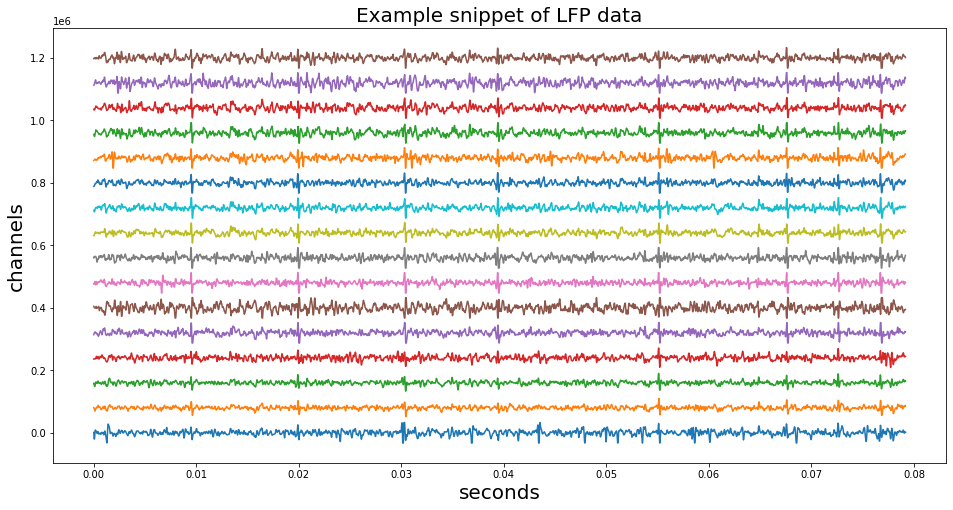

In [101]:
# Plot data from AxonaRecordingExtractor

print(data_axore.shape)
plot_data_snippet(data_axore, start_idx=0, end_idx=data_axore.shape[1], Fs=48000, Nch=16)

__AxonaRawIO__

In [47]:
import neo.rawio
r = neo.rawio.AxonaRawIO(filename=os.path.join(dir_name, base_filename + '.set'))
r.parse_header()
print(r)
        
data_axoraw = r.get_analogsignal_chunk(block_index=0, seg_index=0,
                                       i_start=i_start, i_stop=i_stop,  channel_indexes=None)

AxonaRawIO: ../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/20201004_Raw
nb_block: 1
nb_segment:  [1]
signal_streams: [stream 0 (chans: 16)]
signal_channels: [0a, 0b, 0c, 0d ... 3a , 3b , 3c , 3d]
spike_channels: []
event_channels: []



In [ ]:
num_active_tetrode = 4

elec_per_tetrode = 4
letters = ['a', 'b', 'c', 'd']
dtype = self.data_dtype
units = 'uV'
gain_list = self._get_channel_gain()
offset = 0  # What is the offset?

sig_channels = []
for itetr in range(num_active_tetrode):

    for ielec in range(elec_per_tetrode):

        cntr = (itetr * elec_per_tetrode) + ielec
        ch_name = '{}{}'.format(itetr, letters[ielec])
        chan_id = str(cntr + 1)
        gain = gain_list[cntr]
        stream_id = '0'
        sig_channels.append((ch_name, chan_id, self.sr, dtype,
                             units, gain, offset, stream_id))

return np.array(sig_channels, dtype=_signal_channel_dtype)

(3800, 16)


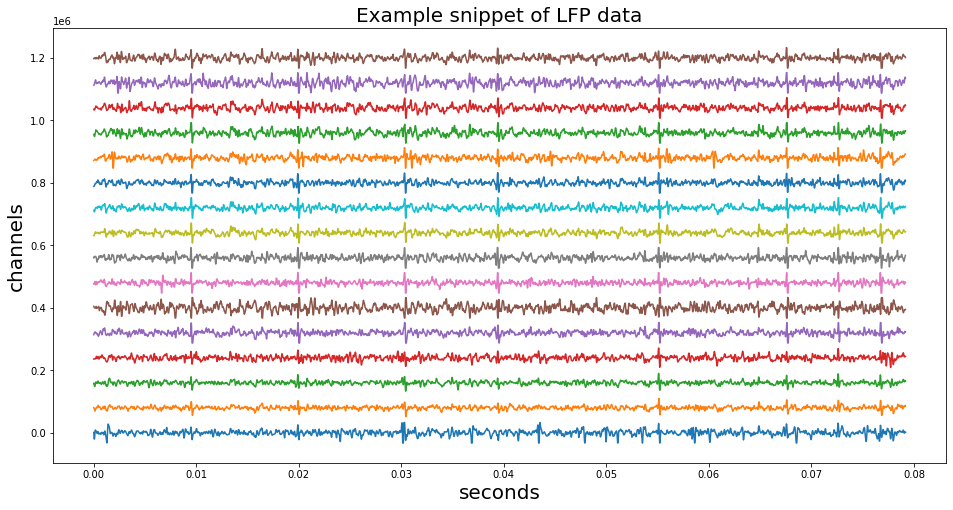

In [48]:
# Plot data from axonarawio

print(data_axoraw.shape)
plot_data_snippet(data_axoraw.T, start_idx=0, end_idx=data_axoraw.shape[0], Fs=48000, Nch=16)

__BinConverter__ (Hussaini lab's code)

In [49]:
# Get data with code snippet from BinConverter, using mmap library:
# https://github.com/HussainiLab/BinConverter/blob/master/BinConverter/core/readBin.py

# 1second = 48000 samples
# 1packet = 3 samples
num_test_samples = 48000 // 3 #num_packets  # read only 1s for testing purposes

bytes_packet = 432
bytes_data = 384
bytes_head = 32
bytes_tail = 16

with open(bin_file, 'rb') as f:

    with contextlib.closing(mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ)) as mmap_obj:
        num_packets = int(len(mmap_obj)/bytes_packet)

        data = np.ndarray(shape=(num_test_samples,), 
                          dtype=(np.int16, (bytes_data//2)),  # replace num_test_samples with num_packets
                          buffer=mmap_obj[0:bytes_packet*num_test_samples],  # ultimately read all
                          offset=bytes_head, 
                          strides=(bytes_packet,)).reshape((-1, 1)).flatten()

data_huss = samples_to_array(data, channels = [])  # remaps channels and converts vector to array

(64, 48000)


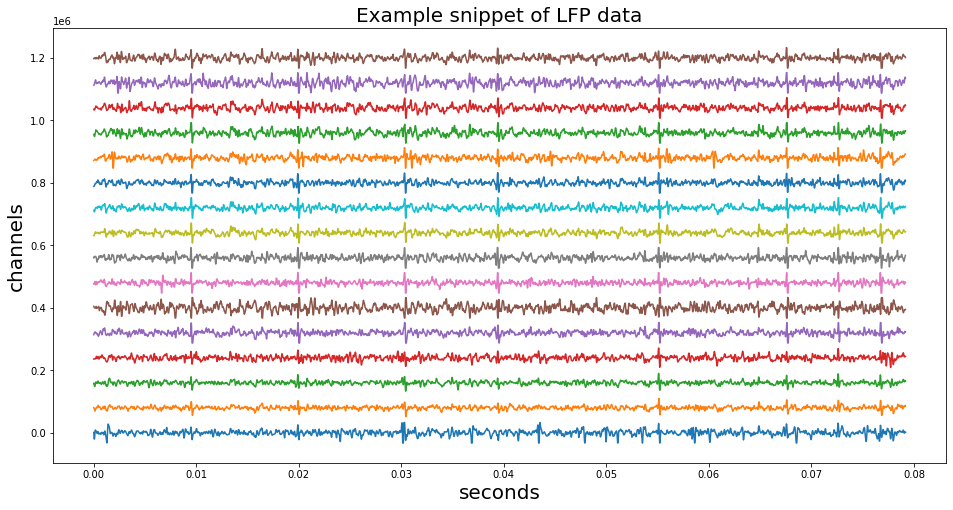

In [50]:
# Plot data from BinConverter (Hussaini lab's code)

print(data_huss.shape)
plot_data_snippet(data_huss, start_idx=i_start, end_idx=i_stop, Fs=48000, Nch=16)

In [51]:
data_axore

NameError: name 'data_axore' is not defined

In [52]:
np.int16(data_huss[0:16,i_start:i_stop])

array([[  1082,  -9584, -18306, ...,   3332,   3128,   1392],
       [   532,  -1012,  -2608, ...,   7152,   7484,   6202],
       [ -1476,  -4154,  -7660, ...,   7724,   7220,   5268],
       ...,
       [ -4236,  -6322,  -6966, ...,   8822,  10228,   8940],
       [ -7436,  -6950,  -5646, ...,  17674,  18298,  15404],
       [ -2234,   -882,   -396, ...,   4808,   3726,   1072]], dtype=int16)

In [53]:
data_axoraw.T

array([[  1082,  -9584, -18306, ...,   3332,   3128,   1392],
       [   532,  -1012,  -2608, ...,   7152,   7484,   6202],
       [ -1476,  -4154,  -7660, ...,   7724,   7220,   5268],
       ...,
       [ -4236,  -6322,  -6966, ...,   8822,  10228,   8940],
       [ -7436,  -6950,  -5646, ...,  17674,  18298,  15404],
       [ -2234,   -882,   -396, ...,   4808,   3726,   1072]], dtype=int16)

In [54]:
# Assert that all give the same array

assert np.array_equal(data_huss[0:16,i_start:i_stop], data_axoraw.T)
assert np.array_equal(np.int16(data_huss[0:16,i_start:i_stop]), data_axore)

NameError: name 'data_axore' is not defined

## Why does CircleCI build fail?

## Comparing methods for reading continuous raw data

I originally tried to speed up Geoffrey's code, but simply using np.memmap seems to be a good solution. We can memory map the entire .bin file, but then dynamically read out the channels and samples we actually want in `_get_analogsignal_chunk()`

In [27]:
# Create memory map

def memory_map(filename, access=mmap.ACCESS_READ):
    size = os.path.getsize(filename)
    print(size)
    file_descriptor = os.open(filename, os.O_RDONLY) 
    return mmap.mmap(file_descriptor, size, access=access)

mmap_obj = memory_map(bin_file)

4147243200


#### Method 1 (mmap - from BinConverter package)
Using python's mmap library, load all channels in one go (but without header and footer), then remap and select channel indeces of interest. This loads a lot of data into memory, and it is difficult to avoid this with this method (though probably possible to improve). np.memmap is a better option - see below.

In [28]:
i_end = 48000
i_start = 0

num_sel_packets = (i_end-i_start) // 3

In [29]:
#%%timeit

# Read all channels at once
data = np.ndarray(shape=(num_sel_packets,), 
                  dtype=(np.int16, (bytes_data//2)),
                  buffer=mmap_obj[i_start:bytes_packet*i_end],
                  offset=bytes_head, 
                  strides=(bytes_packet,)).reshape((-1, 1)).flatten()

arr = samples_to_array(data, channels = [])  # remaps channels and converts vector to array

In [30]:
arr.shape

(64, 48000)

#### Method 2 (np.memmap)
Create numpy.memmap object for the whole .bin file (including header, footer, empty channels...),
and then dynamically only read data into memory as needed (in `_get_analogsignal_chunk()`)

In [53]:

global_header_size = 0
raw_data = np.memmap(bin_file, dtype='int16', mode='r', offset=global_header_size)

print('Size of raw_data:', len(raw_data))
print('Peak at raw_data:', raw_data[16:26])
print('Type of raw_data:', type(raw_data))

Size of raw_data: 2073621600
Peak at raw_data: [ -4384  -6024  -4552 -13192  -7572  -5500    798   2378   1886  -7572]
Type of raw_data: <class 'numpy.memmap'>


In [54]:
# Can we simply select data by indexing? Then we can dynamically create the 
# indeces of the channels and sampled we are interested in!

test_indeces = [2,3,5,1,6,7,139,1284,231938,392318,2182,3824294,200000000]

raw_data[test_indeces]

array([ 1165,     0,     1, 12629,     0,     0,     0,     0,     0,
           0, -3160,     0,     0], dtype=int16)

In [55]:
"""
Return raw (continuous) signals as 2d numpy array (chan x time).
Note that block_index and seg_index are always 1 (regardless of input).

The raw data is in a single vector np.memmap with the following structure:

Each byte packet (432 bytes) has a header (32 bytes), a footer (16 bytes)
and three samples of 2 bytes each for 64 channels (384 bytes), which are 
jumbled up in a strange order. Each channel is remapped to a certain position
(see get_remap_chan), and a channel's samples are allcoated as follows
(example for channel 7):

sample 1: 32b (head) + 2*38b (remappedID) or 2*38b + 1b (second byte of sample)
sample 2: 32b (head) + 128 (all channels 1st entry) + 2*38b (remappedID) or ...
sample 3: 32b (head) + 128*2 (all channels 1st and 2nd entry) + ...
"""
channel_indexes = None
num_channels = 16
i_stop = 48000
i_start = 0

if channel_indexes is None:
    channel_indexes = [i+1 for i in range(num_channels)]

# Each packet has three samples for each channel
# Note this means you can only read out multiples of 3
num_samples = (i_stop-i_start)

# Read one channel at a time
raw_signals = np.ndarray(shape=(num_samples, len(channel_indexes)))
offset = bytes_head // 2


for i, ch_idx in enumerate(channel_indexes):
    chan_offset = get_remap_chan(ch_idx)

    # Create id vector to read data for this channel
    # Note we only consider multiples of three for now
    cur_ids = []
    for isamp in range(num_samples//3):

        cur_ids.extend([isamp*(bytes_packet//2) + offset + chan_offset, 
                        isamp*(bytes_packet//2) + offset + 64 + chan_offset,
                        isamp*(bytes_packet//2) + offset + 64*2 + chan_offset])

    raw_signals[:,i] = raw_data[cur_ids]  

In [56]:
raw_signals.T[0][0:10]

array([ 3682., -3870.,     0.,  3132.,  -124., -1788., -2422., -2052.,
       -1046.,  -102.])

In [57]:
arr[0][0:10]

array([ 3682., -3870.,     0.,  3132.,  -124., -1788., -2422., -2052.,
       -1046.,  -102.])

## Create index vector for memmap on the fly (in get_analogsignal_chunk)

`_get_analogsignal_chunk` will take slightly longer to run, but this will only really be noticeable when the user wants to read in a lot of data at once. In which case the loading is anyway slow. On the other hand with can save quite some time and memory when we do not create this vector unnecessarily for the whole length of the dataset, irrespective of what the user actually wants to read out. 

In [87]:
num_total_packets = int(os.path.getsize(bin_file)/bytes_packet)
num_total_samples = num_packets * 3
print('Number of packets:', num_packets)
print('Number of samples:', num_total_samples)

Number of packets: 9600100
Number of samples: 28800300


[2073477608 2073477672 2073477760 ... 2073621400 2073621464 2073621528]


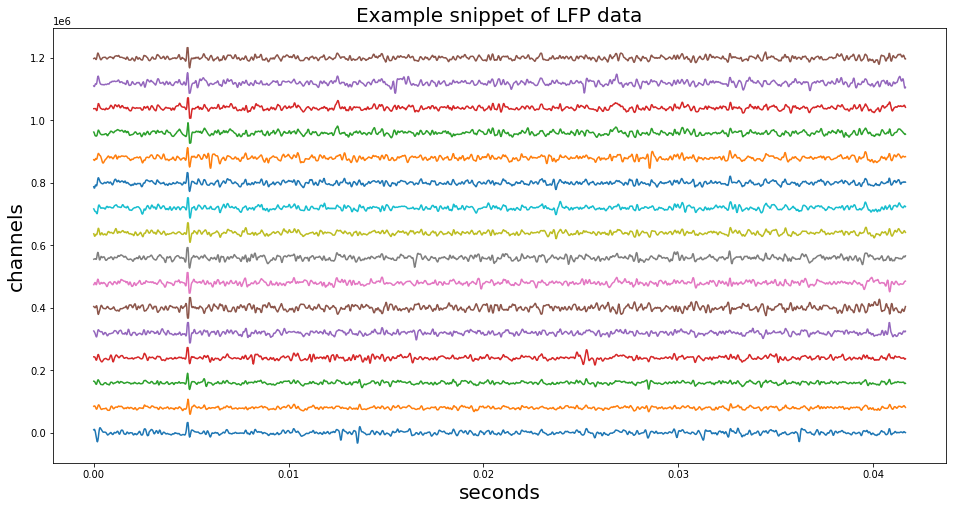

In [88]:
i_start = num_total_samples - 2000
i_stop = num_total_samples

if channel_indexes is None:
        channel_indexes = [i+1 for i in range(num_channels)]
        
num_samples = (i_stop-i_start)

# Create base index vector for _raw_signals for time period of interest
num_packets_oi = (num_samples+2) // 3
offset = i_start//3 * (bytes_packet//2) 
rem = (i_start % 3)

sample1 = np.arange(num_packets_oi+1, dtype=np.uint32)*(bytes_packet//2) + \
              bytes_head//2 + offset
sample2 = sample1 + 64
sample3 = sample2 + 64

sig_ids = np.empty((sample1.size+sample2.size+sample3.size,), dtype=sample1.dtype)
sig_ids[0::3] = sample1
sig_ids[1::3] = sample2
sig_ids[2::3] = sample3
sig_ids = sig_ids[rem:(rem+num_samples)]
print(sig_ids)

# Read one channel at a time
raw_signals = np.ndarray(shape=(len(channel_indexes), num_samples))

for i, ch_idx in enumerate(channel_indexes):

    chan_offset = get_remap_chan(ch_idx)
    raw_signals[i,:] = r._raw_signals[sig_ids + chan_offset]

plot_data_snippet(raw_signals, start_idx=0, end_idx=num_samples, Fs=48000, Nch = 16)

In [89]:
num_channels = 16

In [90]:
def get_signal1(i_start=0, i_stop=2000, channel_indexes=None):

    if channel_indexes is None:
        channel_indexes = [i+1 for i in range(num_channels)]

    num_samples = (i_stop-i_start)

    # Create base index vector for _raw_signals for time period of interest
    num_packets_oi = (num_samples+2) // 3
    
    sample1 = np.arange(num_packets, dtype=np.uint32)*(bytes_packet//2) + \
                  bytes_head//2
    sample2 = sample1 + 64
    sample3 = sample2 + 64

    sig_ids = np.empty((sample1.size+sample2.size+sample3.size,), dtype=sample1.dtype)
    sig_ids[0::3] = sample1
    sig_ids[1::3] = sample2
    sig_ids[2::3] = sample3
    print(sig_ids[i_start:i_stop])

    # Read one channel at a time
    raw_signals = np.ndarray(shape=(len(channel_indexes), num_samples))

    for i, ch_idx in enumerate(channel_indexes):

        chan_offset = get_remap_chan(ch_idx)
        raw_signals[i,:] = r._raw_signals[sig_ids[i_start:i_stop] + chan_offset]
        
    plot_data_snippet(raw_signals, start_idx=0, end_idx=num_samples, Fs=48000, Nch = 16)

    return raw_signals

In [91]:
def get_signal2(i_start=0, i_stop=2000, channel_indexes=None):

    if channel_indexes is None:
        channel_indexes = [i+1 for i in range(num_channels)]

    num_samples = (i_stop-i_start)

    # Create base index vector for _raw_signals for time period of interest
    num_packets_oi = (num_samples+2) // 3
    offset = i_start//3 * (bytes_packet//2) 
    rem = (i_start % 3)
    
    e = 1
    if i_stop == num_samples:
        e = 0
    sample1 = np.arange(num_packets_oi+e, dtype=np.uint32)*(bytes_packet//2) + \
                  bytes_head//2 + offset
    sample2 = sample1 + 64
    sample3 = sample2 + 64

    sig_ids = np.empty((sample1.size+sample2.size+sample3.size,), dtype=sample1.dtype)
    sig_ids[0::3] = sample1
    sig_ids[1::3] = sample2
    sig_ids[2::3] = sample3
    sig_ids = sig_ids[rem:(rem+num_samples)]
    print(sig_ids)

    # Read one channel at a time
    raw_signals = np.ndarray(shape=(len(channel_indexes), num_samples))

    for i, ch_idx in enumerate(channel_indexes):

        chan_offset = get_remap_chan(ch_idx)
        raw_signals[i,:] = r._raw_signals[sig_ids + chan_offset]

    plot_data_snippet(raw_signals, start_idx=0, end_idx=num_samples, Fs=48000, Nch = 16)

    return raw_signals

[2073477608 2073477672 2073477760 ... 2073621400 2073621464 2073621528]


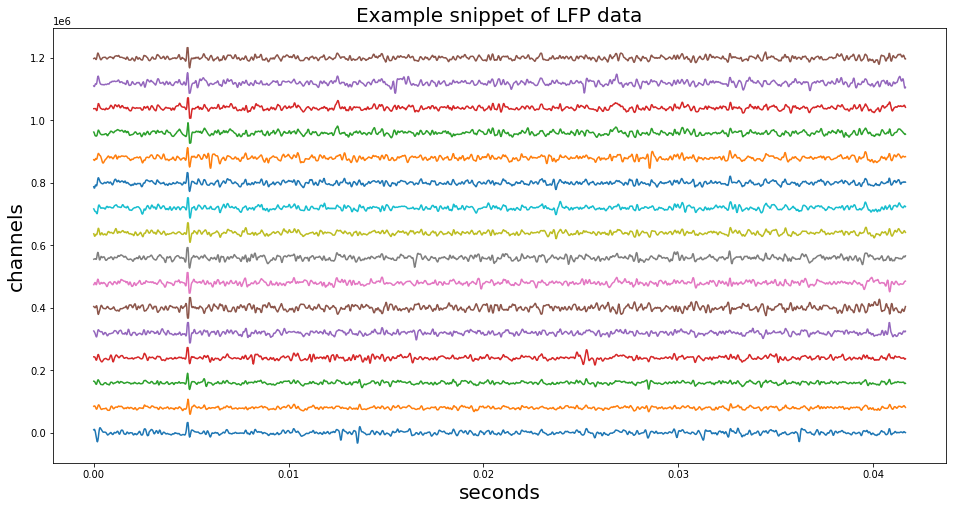

[2073477608 2073477672 2073477760 ... 2073621400 2073621464 2073621528]


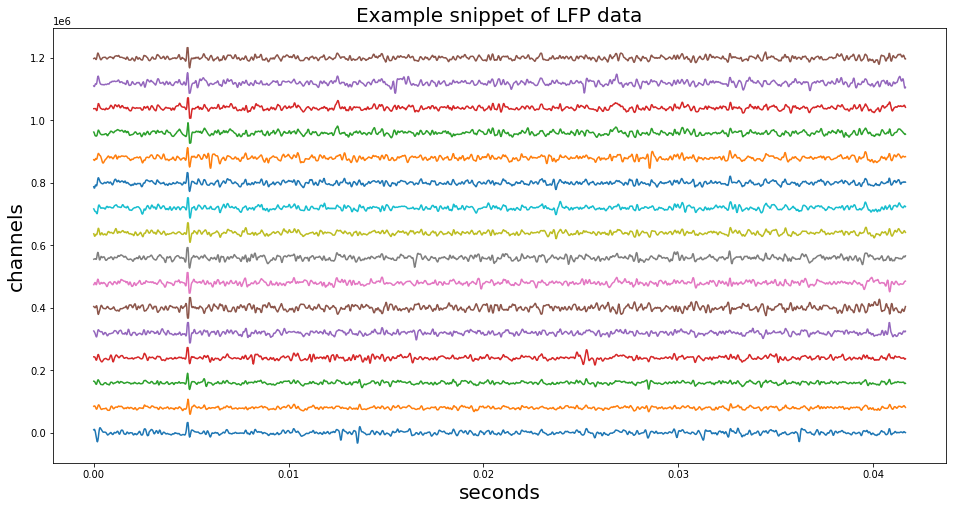

In [92]:
t_start = num_total_samples - 2000
t_stop = num_total_samples

raw_sigs1 = get_signal1(i_start=t_start, i_stop=t_stop)
raw_sigs2 = get_signal2(i_start=t_start, i_stop=t_stop)

assert np.array_equal(raw_sigs1, raw_sigs2)

Note that in my previous implementation using np.linspace, there can easily be issues with non 216-stepsizes from sample to sample. Using np.arange fixes this nicely!

In [93]:
# Compare axonarawio implementation with the implementation in this notebook:

import neo.rawio

r = neo.rawio.AxonaRawIO(filename=os.path.join(dir_name, base_filename))
r.parse_header()
print(r)

AxonaRawIO: ../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_raw/20201004_Raw
nb_block: 1
nb_segment:  [1]
signal_streams: [stream 0 (chans: 16)]
signal_channels: [0a, 0b, 0c, 0d ... 3a , 3b , 3c , 3d]
spike_channels: [unit0, unit1, unit2]
event_channels: [Some events, Some epochs]



<class 'numpy.ndarray'>
(2000, 16)
[[ 9462.  4654.  9968. ... -1758.  8936.  8920.]
 [ 8888.  5646.  8722. ...  -510. 10296.  7662.]
 [ 7330.  5670.  7480. ...  1234. 10962.  4842.]
 ...
 [ 4060. -2814. -3230. ... -1040.  4732.  4992.]
 [ 2216. -3056. -2962. ... -4478.  3066.  5304.]
 [ 1918. -2566. -1924. ... -6932.  3918.  4816.]]


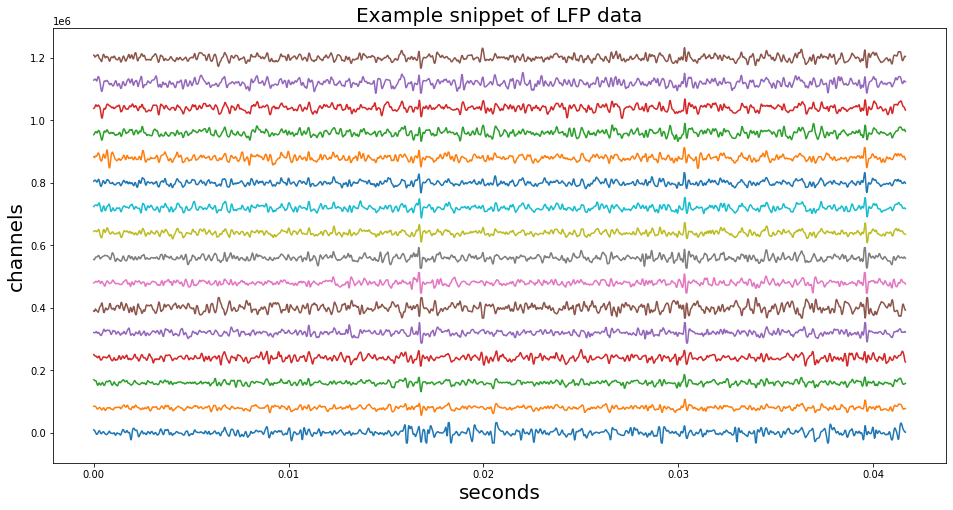

[557424152 557424216 557424304 ... 557567944 557568008 557568072]


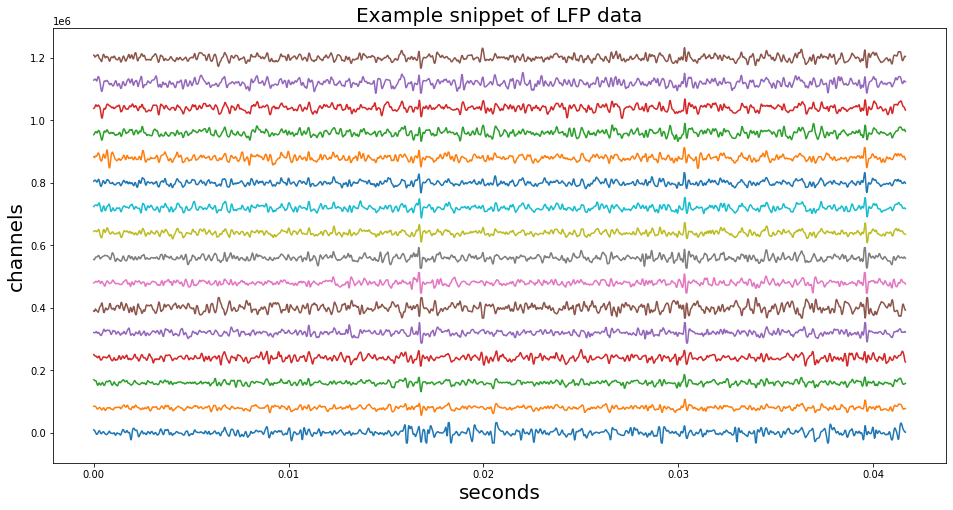

In [96]:
i_start = 7742002
i_stop = i_start + 2000

raw_sigs = r.get_analogsignal_chunk(block_index=0, seg_index=0, 
                                    i_start=i_start, i_stop=i_stop, stream_index=0, channel_indexes=None)

print(type(raw_sigs))
print(raw_sigs.shape)
print(raw_sigs)
plot_data_snippet(raw_sigs.T, start_idx=0, end_idx=i_stop-i_start, Fs=48000, Nch=16)

raw_sigs2 = get_signal2(i_start=i_start, i_stop=i_stop)

# Are the results the same?
assert np.array_equal(raw_sigs.T, raw_sigs2)

Check timing

1. 200000 samples, 16 channels

In [58]:
%%timeit

i_start = 0
i_stop = i_start + 200000

raw_sigs = r.get_analogsignal_chunk(block_index=0, seg_index=0, 
                                    i_start=i_start, i_stop=i_stop, stream_index=0, channel_indexes=None)

77.3 ms ± 24.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


1. 2000000 samples, 16 channels

In [59]:
%%timeit

i_start = 0
i_stop = i_start + 2000000

raw_sigs = r.get_analogsignal_chunk(block_index=0, seg_index=0, 
                                    i_start=i_start, i_stop=i_stop, stream_index=0, channel_indexes=None)

661 ms ± 25.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


1. 28800300 samples, 16 channels

In [60]:
i_start = 0
i_stop = 10000000

raw_sigs = r.get_analogsignal_chunk(block_index=0, seg_index=0, 
                                    i_start=i_start, i_stop=i_stop, stream_index=0, channel_indexes=None)

In [62]:
%%time

i_start = 0
i_stop = 10000000

raw_sigs = r.get_analogsignal_chunk(block_index=0, seg_index=0, 
                                    i_start=i_start, i_stop=i_stop, stream_index=0, channel_indexes=None)

CPU times: user 3.44 s, sys: 7.17 s, total: 10.6 s
Wall time: 46.9 s


In [63]:
print(sys.getsizeof(raw_sigs))

1280000120


# Reading spike and event data

Using examples from the Hussaini lab. Note that in the larger example dataset there are also .egf and .cut files. For now I will focus on the small example dataset, which only contains .set, .eeg, .pos and .X files. 

In [91]:
# Set directory and filename

dir_name = r'../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_units/Axona_Unit_Mode_SmallFile'
base_filename = '20140815-180secs'

unit_set_file = os.path.join(dir_name, base_filename + '.set')
unit_eeg_file = os.path.join(dir_name, base_filename + '.eeg')
unit_pos_file = os.path.join(dir_name, base_filename + '.pos')
unit_num_file1 = os.path.join(dir_name, base_filename + '.1')
unit_num_file2 = os.path.join(dir_name, base_filename + '.2')
unit_num_file3 = os.path.join(dir_name, base_filename + '.3')
unit_num_file4 = os.path.join(dir_name, base_filename + '.4')

print('Reading UNIT data files:')
print(unit_set_file)
print(unit_eeg_file)
print(unit_pos_file)
print(unit_num_file1)
print(unit_num_file2)
print(unit_num_file3)
print(unit_num_file4)

Reading UNIT data files:
../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_units/Axona_Unit_Mode_SmallFile/20140815-180secs.set
../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_units/Axona_Unit_Mode_SmallFile/20140815-180secs.eeg
../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_units/Axona_Unit_Mode_SmallFile/20140815-180secs.pos
../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_units/Axona_Unit_Mode_SmallFile/20140815-180secs.1
../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_units/Axona_Unit_Mode_SmallFile/20140815-180secs.2
../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_units/Axona_Unit_Mode_SmallFile/20140815-180secs.3
../../freelance-work/catalyst-neuro/hussaini-lab-to-nwb/example_data_units/Axona_Unit_Mode_SmallFile/20140815-180secs.4


## System setup files (“.set”) - this is the same for the continuous recording
The “.set” file is a master file which contains information relating to the hardware settings
of the system, including things like channel gains and signal routing, filter configurations,
tracker setup, etc. Everything that can be set in dacq2 in a way that persists between
program runs will be stored in the “.set” file. 

In [77]:
with open(unit_set_file, 'rb') as f:
    content = f.read()
    
print(sys.getsizeof(content))
print(content[0:100].decode('ascii'))

26010
trial_date Friday, 15 Aug 2014
trial_time 15:21:10
experimenter Abid
comments 
duration 180
sw_


## EEG data files (“.eeg”, “.eegX”, “.egf”, “.egfX”)
EEG data is usually recorded continuously at 250 Hz in unit recording mode. The “.eeg”
and “.eg2” files contain the data from the primary and secondary EEG channels, if these
have been enabled. Very simply, the data consist of “num_EEG_samples” data bytes,
following on from the data_start. The sample count is specified in the header. The “.egf”
file is stored if a user selects a higher-sample rate EEG. Samples are normally collected
at 4800 Hz (specified in the header), and are also normally 2 bytes long, rather than just 1. 


The header information in this file has specific key words, which sometimes have values and sometimes not.
For now, read all key-words into a dictionary and assign the correspdoning value as strings. We can later see
if we want to change certain values into integers or datetimes. 

In [188]:
with open(unit_eeg_file, 'rb') as f:
    eeg_head = f.read(50000)
    
start_of_eeg = eeg_head.find(b'data_start') + len('data_start')
print(start_of_eeg)

246


In [193]:
# This is where the EEG data starts

print(eeg_head.decode('cp1252')[start_of_eeg-1])
eeg_head.decode('cp1252')[start_of_eeg]

t


'\x00'

In [160]:
eeg_head = eeg_head[:eeg_head.find(b'data_start')]
eeg_head

b'trial_date Friday, 15 Aug 2014\r\ntrial_time 15:21:10\r\nexperimenter Abid\r\ncomments \r\nduration 180       \r\nsw_version 1.2.2.16\r\nnum_chans 1\r\nsample_rate 250.0 hz\r\nEEG_samples_per_position 5\r\nbytes_per_sample 1\r\nnum_EEG_samples 45000     \r\n'

In [161]:
eeg_head = eeg_head.decode('cp1252').replace('\r\n', 'SEPARATOR').replace('\r', 'SEPARATOR')
eeg_head

'trial_date Friday, 15 Aug 2014SEPARATORtrial_time 15:21:10SEPARATORexperimenter AbidSEPARATORcomments SEPARATORduration 180       SEPARATORsw_version 1.2.2.16SEPARATORnum_chans 1SEPARATORsample_rate 250.0 hzSEPARATOREEG_samples_per_position 5SEPARATORbytes_per_sample 1SEPARATORnum_EEG_samples 45000     SEPARATOR'

In [165]:
header = {}
key_words = ['trial_date', 'trial_time', 'experimenter', 'comments', 'duration', 
             'sw_version', 'num_chans', 'sample_rate', 'EEG_samples_per_position', 
             'bytes_per_sample', 'num_EEG_samples']

base_re = '\s(.*?)SEPARATOR'
for key in key_words:
    header[key] = re.findall(key + base_re, eeg_head)[0].strip()

header

{'trial_date': 'Friday, 15 Aug 2014',
 'trial_time': '15:21:10',
 'experimenter': 'Abid',
 'comments': '',
 'duration': '180',
 'sw_version': '1.2.2.16',
 'num_chans': '1',
 'sample_rate': '250.0 hz',
 'EEG_samples_per_position': '5',
 'bytes_per_sample': '1',
 'num_EEG_samples': '45000'}

Next, let's read out the EEG data. Note that the number of bytes per sample are given in the header!

In [216]:
eeg_data = np.memmap(unit_eeg_file, dtype='int'+str(int(header['bytes_per_sample'])*8), mode='r', offset=start_of_eeg)

In [222]:
print(eeg_data.shape)

(45012,)


In [217]:
eeg_data[0:3]

memmap([0, 0, 3], dtype=int8)

In [219]:
print(len(eeg_data))
print(header['num_EEG_samples'])


print(eeg_data[0:5])


print(eeg_data[-12:])
print(eeg_data[45000::])

# Why do we have more samples than indicated in the header?!

45012
45000
[ 0  0  3 -6  0]
[ 13  10 100  97 116  97  95 101 110 100  13  10]
[ 13  10 100  97 116  97  95 101 110 100  13  10]


In [221]:
# The last 24 bytes are a footer!

with open(unit_eeg_file, 'rb') as f:
    test = f.read()
    
test[-12:]

b'\r\ndata_end\r\n'

In [246]:
header = {}
with open(unit_eeg_file, 'rb') as f:
    for bin_line in f:
        if b'data_start' in bin_line:
            break
        line = bin_line.decode('cp1252').replace('\r\n', '').replace('\r', '').strip()
        parts = line.split(' ')
        key = parts[0]
        value = ' '.join(parts[1:])
        header[key] = value

[print(k, v) for k, v in header.items()]
header

trial_date Friday, 15 Aug 2014
trial_time 15:21:10
experimenter Abid
comments 
duration 180
sw_version 1.2.2.16
num_chans 1
sample_rate 250.0 hz
EEG_samples_per_position 5
bytes_per_sample 1
num_EEG_samples 45000


{'trial_date': 'Friday, 15 Aug 2014',
 'trial_time': '15:21:10',
 'experimenter': 'Abid',
 'comments': '',
 'duration': '180',
 'sw_version': '1.2.2.16',
 'num_chans': '1',
 'sample_rate': '250.0 hz',
 'EEG_samples_per_position': '5',
 'bytes_per_sample': '1',
 'num_EEG_samples': '45000'}

In [248]:
def parse_generic_header(filename):
    """
    Given a binary file with phrases and line breaks, enters the
    first word of a phrase as dictionary key and the following
    string (without linebreaks) as value. Returns the dictionary.
    """
    header = {}
    with open(filename, 'rb') as f:
        for bin_line in f:
            if b'data_start' in bin_line:
                break
            line = bin_line.decode('cp1252').replace('\r\n', '').replace('\r', '').strip()
            parts = line.split(' ')
            key = parts[0]
            value = ' '.join(parts[1:])
            header[key] = value
            
    return header

In [249]:
parse_generic_header(unit_eeg_file)

{'trial_date': 'Friday, 15 Aug 2014',
 'trial_time': '15:21:10',
 'experimenter': 'Abid',
 'comments': '',
 'duration': '180',
 'sw_version': '1.2.2.16',
 'num_chans': '1',
 'sample_rate': '250.0 hz',
 'EEG_samples_per_position': '5',
 'bytes_per_sample': '1',
 'num_EEG_samples': '45000'}

In [94]:
with open(unit_eeg_file, 'rb') as f:
    eeg = f.read()
    
print(sys.getsizeof(eeg))
print(eeg[0:300])

45291
b'trial_date Friday, 15 Aug 2014\r\ntrial_time 15:21:10\r\nexperimenter Abid\r\ncomments \r\nduration 180       \r\nsw_version 1.2.2.16\r\nnum_chans 1\r\nsample_rate 250.0 hz\r\nEEG_samples_per_position 5\r\nbytes_per_sample 1\r\nnum_EEG_samples 45000     \r\ndata_start\x00\x00\x03\xfa\x00\x07\xfc\xf5\xfa\xf9\xee\xef\xef\xf3\xfa\t\x06\t\x02\xfc\xf8\xfb\x00\x02\x02\x01\x03\x03\x03\x04\x03\x0b\t\x03\xf6\xfb\xf3\xf8\xf9\x00\x07\x10\x07\x03\x01\xfe\xfe\xfc\xf7\xeb\xf5\xfa\x02\x00'


- TODO: Do I have a file with more than a single channel?
- TODO: Parse header information properly (convert strings to datetime, integers, floats etc., where appropriate)

## Position files (“.pos”)
The format of the “.pos” file depends on the tracking mode. Each position sample is 20
bytes long, and consists of a 4-byte frame counter (incremented at around 50 Hz,
according to the camera sync signal), and then 8 2-byte words. In four-spot mode, the 8
words are redx, redy, greenx, greeny, bluex, bluey, whitex, whitey. In two-spot mode, they
are big_spotx, big_spoty, little_spotx, little_spoty, number_of_pixels_in_big_spot,
number_of_pixels_in_little_spot, total_tracked_pixels, and the 8th word is unused. Each
word is MSB-first. If a position wasn't tracked (e.g., the light was obscured), then the
values for x and y will both be 0x3ff (= 1023). The header contains things like the limits of
the tracking window in pixels, etc.
Note: the frame counter is NOT a timestamp for the position samples. It should be
ignored in analyses. The samples are obtained at regular intervals so the Xth sample in
the file was taken at time X/50 seconds since the start of the recording session. 

In [227]:
with open(unit_pos_file, 'rb') as f:
    pos = f.read()
    
print(sys.getsizeof(pos))
print(pos[0:600])

180586
b'trial_date Friday, 15 Aug 2014\r\ntrial_time 15:21:10\r\nexperimenter Abid\r\ncomments \r\nduration 180       \r\nsw_version 1.2.2.16\r\nnum_colours 4\r\nmin_x 0\r\nmax_x 768\r\nmin_y 0\r\nmax_y 574\r\nwindow_min_x 220\r\nwindow_max_x 473\r\nwindow_min_y 159\r\nwindow_max_y 420\r\ntimebase 50 hz\r\nbytes_per_timestamp 4\r\nsample_rate 50.0 hz\r\nEEG_samples_per_position 5\r\nbearing_colour_1 0\r\nbearing_colour_2 0\r\nbearing_colour_3 0\r\nbearing_colour_4 0\r\npos_format t,x1,y1,x2,y2,numpix1,numpix2\r\nbytes_per_coord 2\r\npixels_per_metre 300\r\nnum_pos_samples 9000      \r\ndata_start\x00\x00\x00\x00\x00\n\x00\xc3\x03\xff\x03\xff\x00\x04\x00\x00\x00\x04\x00\x00\x00\x00\x00\x01\x00\x0c\x00\xc0\x03\xff\x03\xff\x00\x06\x00\x00\x00\x06\x00\x00\x00\x00\x00\x02\x00\x06\x00\xc2\x03\xff\x03\xff\x00\x08\x00\x00\x00\x08\x00'


In [250]:
pos_header = parse_generic_header(unit_pos_file)
pos_header

{'trial_date': 'Friday, 15 Aug 2014',
 'trial_time': '15:21:10',
 'experimenter': 'Abid',
 'comments': '',
 'duration': '180',
 'sw_version': '1.2.2.16',
 'num_colours': '4',
 'min_x': '0',
 'max_x': '768',
 'min_y': '0',
 'max_y': '574',
 'window_min_x': '220',
 'window_max_x': '473',
 'window_min_y': '159',
 'window_max_y': '420',
 'timebase': '50 hz',
 'bytes_per_timestamp': '4',
 'sample_rate': '50.0 hz',
 'EEG_samples_per_position': '5',
 'bearing_colour_1': '0',
 'bearing_colour_2': '0',
 'bearing_colour_3': '0',
 'bearing_colour_4': '0',
 'pos_format': 't,x1,y1,x2,y2,numpix1,numpix2',
 'bytes_per_coord': '2',
 'pixels_per_metre': '300',
 'num_pos_samples': '9000'}

## Tetrode/stereotrode data files (“.1” to “.32”)

Data from tetrode 1 (or stereotrodes 1 and 2) is stored in the “.1” file. Similarly, data from tetrode N is stored in file “.N”, where N ranges up to 32. There are two general recording
modes at present. The first is unit mode, and the second raw mode.

### Unit mode
In unit mode, data is stored in 1 ms chunks, 200 µs and 800 µs after a threshold event. The header will contain a setting called “spike_format”. Generally, there are 216 bytes per spike, structured as 54 bytes per channel, in order by channel number (so, for tetrode 1, the channels are in the order 1, 2, 3, 4, or actually 1a, 1b, 1c, 1d in dacq2 nomenclature, etc.). The 54 bytes consist of a 4 byte time stamp (most significant byte first), then 50 8-bit samples. The ASCII header specifies you how many spikes there should be in the file (“num_spikes”), and <b style="color:red"> the “timebase” of the timestamps (almost always 96 kHz, which
means the 4-byte timestamp value needs to be divided by 96000 to get a time in seconds). The samples themselves are normally collected at 48 kHz (again, specified in the header).</b> ... Why is the "timebase" Fs different from the recording Fs?

Tetrode and stereotrode data is almost identical, in that both store 4-channels worth of data per spike. The only difference is that in stereotrode mode, either channels 3&4 or 1&2 will be all zeroes, corresponding to a spike on stereotrode 1 or 2, respectively (the stereotrode format is very wasteful of file space).

### Raw mode
In raw mode, data is stored continuously, rather than in spike packets. The header will contain a setting called “raw_format”. It will also contain “num_samples”, which specifies how many samples have been collected, and at which “sample_rate”. Samples are normally 16-bit, but in any case this is specified by “bytes_per_sample” in the header. 


In [92]:
with open(unit_num_file1, 'rb') as f:
    num = f.read()
print('file.1:', sys.getsizeof(num))
print(num[0:300])

with open(unit_num_file2, 'rb') as f:
    num = f.read()
print('file.2:', sys.getsizeof(num))
print(num[0:300])

with open(unit_num_file3, 'rb') as f:
    num = f.read()
print('file.3:', sys.getsizeof(num))
print(num[0:300])

with open(unit_num_file4, 'rb') as f:
    num = f.read()
print('file.4:', sys.getsizeof(num))
print(num[0:300])

file.1: 3443616
b'trial_date Friday, 15 Aug 2014\r\ntrial_time 15:21:10\r\nexperimenter Abid\r\ncomments \r\nduration 180       \r\nsw_version 1.2.2.16\r\nnum_chans 4\r\ntimebase 96000 hz\r\nbytes_per_timestamp 4\r\nsamples_per_spike 50\r\nsample_rate 48000 hz\r\nbytes_per_sample 1\r\nspike_format t,ch1,t,ch2,t,ch3,t,ch4\r\nnum_spikes 15941  '
file.2: 3861576
b'trial_date Friday, 15 Aug 2014\r\ntrial_time 15:21:10\r\nexperimenter Abid\r\ncomments \r\nduration 180       \r\nsw_version 1.2.2.16\r\nnum_chans 4\r\ntimebase 96000 hz\r\nbytes_per_timestamp 4\r\nsamples_per_spike 50\r\nsample_rate 48000 hz\r\nbytes_per_sample 1\r\nspike_format t,ch1,t,ch2,t,ch3,t,ch4\r\nnum_spikes 17876  '
file.3: 1397448
b'trial_date Friday, 15 Aug 2014\r\ntrial_time 15:21:10\r\nexperimenter Abid\r\ncomments \r\nduration 180       \r\nsw_version 1.2.2.16\r\nnum_chans 4\r\ntimebase 96000 hz\r\nbytes_per_timestamp 4\r\nsamples_per_spike 50\r\nsample_rate 48000 hz\r\nbytes_per_sample 1\r\nspike_format t,ch1,t,c

In [252]:
num1_header = parse_generic_header(unit_num_file1)
num1_header  # contains either "spike_format" or "raw_format" as key (for unit or raw mode respectively)

{'trial_date': 'Friday, 15 Aug 2014',
 'trial_time': '15:21:10',
 'experimenter': 'Abid',
 'comments': '',
 'duration': '180',
 'sw_version': '1.2.2.16',
 'num_chans': '4',
 'timebase': '96000 hz',
 'bytes_per_timestamp': '4',
 'samples_per_spike': '50',
 'sample_rate': '48000 hz',
 'bytes_per_sample': '1',
 'spike_format': 't,ch1,t,ch2,t,ch3,t,ch4',
 'num_spikes': '15941'}

In [ ]:
# eof